In [7]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [8]:
import glob
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define base directory paths
DATA_DIR = 'data_synced'  # Directory containing processed CSV files and frame folders

class SequentialDrivingDataset(Dataset):
    def __init__(self, csv_file, sequence_length=10, transform=None):
        self.sequence_length = sequence_length
        self.data = pd.read_csv(csv_file)
        
        # Get frames directory path from CSV filename
        base_dir = os.path.dirname(csv_file)
        filename = os.path.basename(csv_file)
        self.frames_dir = os.path.join(base_dir, f"{filename[:-4]}_frames")
        
        # Verify frames directory exists
        if not os.path.exists(self.frames_dir):
            raise FileNotFoundError(f"Frames directory not found: {self.frames_dir}")
        
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])
        
        # Create sequences
        self.sequences = []
        total_frames = len(self.data)
        for i in range(total_frames - sequence_length + 1):
            self.sequences.append(i)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence_start = self.sequences[idx]
        
        # Initialize sequence containers
        image_sequence = []
        sensor_sequence = []
        target_sequence = []
        
        # Build sequence
        for i in range(self.sequence_length):
            frame_idx = sequence_start + i
            row = self.data.iloc[frame_idx]
            
            # Load image
            frame_path = os.path.join(self.frames_dir, f"{int(row['frame_idx'])}.jpg")
            frame = Image.open(frame_path).convert('RGB')
            if self.transform:
                frame = self.transform(frame)
            image_sequence.append(frame)
            
            # Get sensor data
            speed_value = float(row['speed'].strip('[]') if isinstance(row['speed'], str) else row['speed'])
            sensor_data = torch.tensor([
                speed_value,
                row['gyro_x'], row['gyro_y'], row['gyro_z'],
                row['accel_x'], row['accel_y'], row['accel_z'],
                row['velocity_x'], row['velocity_y'], row['velocity_z'],
                row['current_steering'],
            ], dtype=torch.float32)
            sensor_sequence.append(sensor_data)
            
            # Get target (future steering angle)
            target = torch.tensor(row['future_steering'], dtype=torch.float32)
            target_sequence.append(target)
        
        # Stack sequences
        image_sequence = torch.stack(image_sequence)
        sensor_sequence = torch.stack(sensor_sequence)
        target_sequence = torch.stack(target_sequence)
        
        return image_sequence, sensor_sequence, target_sequence

def visualize_sample_datapoints(dataset, num_samples=4):
    """
    Visualize a few sample datapoints from the dataset to verify format
    """
    fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        # Get a random sample
        idx = np.random.randint(len(dataset))
        image, sensor_data, target = dataset[idx]
        
        # Convert image tensor back to displayable format
        img = image.numpy().transpose(1, 2, 0)
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Plot image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')
        
        # Create sensor data visualization
        sensor_labels = [
            'Speed', 
            'Gyro X', 'Gyro Y', 'Gyro Z',
            'Accel X', 'Accel Y', 'Accel Z',
            'Velocity X', 'Velocity Y', 'Velocity Z',
            'Current Steering'
        ]
        
        # Plot sensor data as a bar chart
        axes[i, 1].bar(sensor_labels, sensor_data.numpy())
        axes[i, 1].set_title(f'Sensor Data (Future Steering: {target:.2f}°)')
        axes[i, 1].tick_params(axis='x', rotation=45)
        axes[i, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Get list of all CSV files in data_synced
csv_files = [f for f in glob.glob('data_synced/*.csv') if 'combined_dataset.csv' not in f]
print(f"Found {len(csv_files)} CSV files")

# Create datasets for each segment
datasets = []
for csv_file in tqdm(csv_files, desc="Loading datasets"):
    try:
        dataset = DrivingDataset(csv_file)
        datasets.append(dataset)
        print(f"Successfully loaded dataset from {csv_file}")
    except Exception as e:
        print(f"Error loading {csv_file}: {str(e)}")
        continue

if not datasets:
    raise RuntimeError("No datasets were successfully loaded!")

# Combine all datasets
full_dataset = ConcatDataset(datasets)
total_size = len(full_dataset)

# Split dataset into train, validation, and test sets (70%, 15%, 15%)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

print(f"\nDataset sizes:")
print(f"Total samples: {total_size}")
print(f"Train: {len(train_dataset)} ({len(train_dataset)/total_size*100:.1f}%)")
print(f"Validation: {len(val_dataset)} ({len(val_dataset)/total_size*100:.1f}%)")
print(f"Test: {len(test_dataset)} ({len(test_dataset)/total_size*100:.1f}%)")

# Create data loaders with no workers for simplicity
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

# Visualize some samples to verify data format
print("\nVisualizing sample datapoints from training set...")
visualize_sample_datapoints(train_dataset)

Found 7 CSV files


Loading datasets:   0%|          | 0/7 [00:00<?, ?it/s]

CSV file: data_synced\b0c9d2329ad1606b_2018-07-27--06-03-57_6.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-27--06-03-57\6\video.hevc
Loading video frames...
CSV file: data_synced\b0c9d2329ad1606b_2018-07-27--06-50-48_7.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-27--06-50-48\7\video.hevc
CSV file: data_synced\b0c9d2329ad1606b_2018-07-27--06-50-48_12.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-27--06-50-48\12\video.hevc
Loading video frames...
Loading video frames...
CSV file: data_synced\b0c9d2329ad1606b_2018-07-29--11-17-20_4.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-29--11-17-20\4\video.hevc
Loading video frames...


Loading datasets:  14%|█▍        | 1/7 [00:08<00:51,  8.54s/it]

Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-29--11-17-20_4.csv
CSV file: data_synced\b0c9d2329ad1606b_2018-07-29--12-02-42_27.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-29--12-02-42\27\video.hevc
Loading video frames...
Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-27--06-50-48_12.csv
Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-27--06-50-48_7.csv
CSV file: data_synced\b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-29--12-02-42\30\video.hevc
Loading video frames...
CSV file: data_synced\b0c9d2329ad1606b_2018-07-30--13-03-07_16.csv
Video path: data/extracted/Chunk_1\b0c9d2329ad1606b_2018-07-30--13-03-07\16\video.hevc
Loading video frames...
Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-27--06-03-57_6.csv


Loading datasets: 100%|██████████| 7/7 [00:16<00:00,  2.34s/it]

Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-29--12-02-42_27.csv
Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-30--13-03-07_16.csv
Successfully loaded dataset from data_synced\b0c9d2329ad1606b_2018-07-29--12-02-42_30.csv

Dataset sizes:
Total samples: 8376
Train: 5863 (70.0%)
Validation: 1256 (15.0%)
Test: 1257 (15.0%)


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

class ResBlock(nn.Module):
    """
    Basic ResNet block with optional downsampling.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        
        # First convolution block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second convolution block
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection (identity or 1x1 conv)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Skip connection
        out = F.relu(out)
        return out

class SteeringResNet(nn.Module):
    """
    ResNet-based model for predicting steering angles at t+200ms.
    Architecture:
    1. Initial Conv layer
    2. ResNet blocks with increasing channels
    3. Sensor processing branch
    4. Combined processing for final prediction
    """
    def __init__(self):
        super(SteeringResNet, self).__init__()
        self.sensor_input_size = 11  # speed, gyro(3), accel(3), velocity(3), current_steering

        # Initial processing
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # ResNet blocks
        self.layer1 = self._make_layer(64, 64, 2)    # Output: 64 channels
        self.layer2 = self._make_layer(64, 128, 2, stride=2)  # Output: 128 channels
        self.layer3 = self._make_layer(128, 256, 2, stride=2)  # Output: 256 channels
        
        # Sensor processing branch
        self.sensor_net = nn.Sequential(
            nn.Linear(self.sensor_input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )

        # Calculate final feature size
        with torch.no_grad():
            dummy_img = torch.zeros(1, 3, 240, 400)
            dummy_features = self.initial(dummy_img)
            dummy_features = self.layer1(dummy_features)
            dummy_features = self.layer2(dummy_features)
            dummy_features = self.layer3(dummy_features)
            self.feature_size = dummy_features.view(-1).shape[0]
            print(f"CNN Feature size: {self.feature_size}")

        # Combined processing
        self.final = nn.Sequential(
            nn.Linear(self.feature_size + 64, 256),  # CNN features + sensor features
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),  # Small dropout for regularization
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 1)
        )

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        """Helper function to create a layer of ResBlocks"""
        layers = []
        layers.append(ResBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, image, sensor_data):
        """
        Forward pass through the network.
        Args:
            image (torch.Tensor): Shape [B, 3, 240, 400]
            sensor_data (torch.Tensor): Shape [B, 11]
        Returns:
            torch.Tensor: Predicted steering angle at t+200ms, shape [B, 1]
        """
        # Image processing branch
        x = self.initial(image)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)  # Flatten CNN features

        # Sensor processing branch
        sensor_features = self.sensor_net(sensor_data)

        # Combine features
        combined = torch.cat([x, sensor_features], dim=1)
        
        # Final prediction
        steering = self.final(combined)
        return steering

In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    """
    Train the model with early stopping.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Add this before training starts
    print("\nGPU Information:")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Device name: {torch.cuda.get_device_name()}")
        print(f"Device memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    model.to(device)
    print(f"Training on {device}")

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Use tqdm for progress bar
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for images, sensor_data, targets in pbar:
                images = images.to(device)
                sensor_data = sensor_data.to(device)
                targets = targets.to(device).view(-1, 1)  # Future steering angle

                optimizer.zero_grad()
                outputs = model(images, sensor_data)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                pbar.set_postfix({'loss': loss.item()})

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0

        with torch.no_grad():
            for images, sensor_data, targets in val_loader:
                images = images.to(device)
                sensor_data = sensor_data.to(device)
                targets = targets.to(device).view(-1, 1)

                outputs = model(images, sensor_data)
                loss = criterion(outputs, targets)
                running_loss += loss.item() * images.size(0)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

        # Early stopping check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)

    # Plot training curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, train_losses, val_losses

In [15]:
def test_model(model, test_loader):
    """
    Test the model with steering-specific metrics for future steering angle prediction.
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, sensor_data, target_angle in test_loader:  # Now unpacking three values
            images = images.to(device)
            sensor_data = sensor_data.to(device)
            target_angle = target_angle.to(device).view(-1, 1)  # Future steering angle

            outputs = model(images, sensor_data)
            all_preds.extend(outputs.cpu().numpy())
            all_targets.extend(target_angle.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Calculate metrics
    mse = np.mean((all_preds - all_targets) ** 2)
    mae = np.mean(np.abs(all_preds - all_targets))
    within_1_deg = np.mean(np.abs(all_preds - all_targets) < 1.0) * 100
    within_3_deg = np.mean(np.abs(all_preds - all_targets) < 3.0) * 100
    within_5_deg = np.mean(np.abs(all_preds - all_targets) < 5.0) * 100

    print("\nTest Results (Predicting Steering Angle at t+200ms):")
    print(f"MSE: {mse:.4f} degrees²")
    print(f"MAE: {mae:.4f} degrees")
    print(f"Predictions within 1°: {within_1_deg:.1f}%")
    print(f"Predictions within 3°: {within_3_deg:.1f}%")
    print(f"Predictions within 5°: {within_5_deg:.1f}%")

    # Visualizations
    plt.figure(figsize=(15, 5))

    # Prediction vs Ground Truth
    plt.subplot(1, 2, 1)
    plt.plot(all_targets[:100], label='Future Ground Truth')
    plt.plot(all_preds[:100], label='Predicted Future')
    plt.xlabel('Sample')
    plt.ylabel('Steering Angle (degrees)')
    plt.title('Predicted vs Actual Future Steering Angles')
    plt.legend()

    # Correlation plot
    plt.subplot(1, 2, 2)
    plt.scatter(all_targets, all_preds, alpha=0.1)
    plt.plot([-45, 45], [-45, 45], 'r--')
    plt.xlabel('Actual Future Steering Angle (degrees)')
    plt.ylabel('Predicted Future Steering Angle (degrees)')
    plt.title('Prediction Correlation (t+200ms)')

    plt.tight_layout()
    plt.show()

CNN Feature size: 96000

GPU Information:
CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4090
Device memory: 25.76 GB
Training on cuda:0


Epoch 1/50: 100%|██████████| 66/66 [00:07<00:00,  8.48it/s, loss=9.51]


Epoch 1: Train Loss: 22.3506, Val Loss: 8.2348


Epoch 2/50: 100%|██████████| 66/66 [00:07<00:00,  9.01it/s, loss=14.5]


Epoch 2: Train Loss: 8.2453, Val Loss: 5.9174


Epoch 3/50: 100%|██████████| 66/66 [00:07<00:00,  9.08it/s, loss=3.33] 


Epoch 3: Train Loss: 4.9948, Val Loss: 2.8795


Epoch 4/50: 100%|██████████| 66/66 [00:07<00:00,  9.03it/s, loss=3.63] 


Epoch 4: Train Loss: 4.2932, Val Loss: 2.5462


Epoch 5/50: 100%|██████████| 66/66 [00:07<00:00,  9.20it/s, loss=2.65] 


Epoch 5: Train Loss: 3.9555, Val Loss: 2.3564


Epoch 6/50: 100%|██████████| 66/66 [00:07<00:00,  8.99it/s, loss=7.9]  


Epoch 6: Train Loss: 3.4936, Val Loss: 2.3660


Epoch 7/50: 100%|██████████| 66/66 [00:07<00:00,  9.02it/s, loss=7.56] 


Epoch 7: Train Loss: 2.8507, Val Loss: 0.9156


Epoch 8/50: 100%|██████████| 66/66 [00:07<00:00,  8.84it/s, loss=2.37] 


Epoch 8: Train Loss: 3.4407, Val Loss: 1.2773


Epoch 9/50: 100%|██████████| 66/66 [00:07<00:00,  9.00it/s, loss=4.2]  


Epoch 9: Train Loss: 2.9215, Val Loss: 1.3747


Epoch 10/50: 100%|██████████| 66/66 [00:07<00:00,  9.22it/s, loss=3]    


Epoch 10: Train Loss: 2.6583, Val Loss: 0.9034


Epoch 11/50: 100%|██████████| 66/66 [00:07<00:00,  8.94it/s, loss=2.01] 


Epoch 11: Train Loss: 2.5636, Val Loss: 1.2575


Epoch 12/50: 100%|██████████| 66/66 [00:07<00:00,  8.97it/s, loss=6.07] 


Epoch 12: Train Loss: 2.3995, Val Loss: 1.0149


Epoch 13/50: 100%|██████████| 66/66 [00:07<00:00,  9.07it/s, loss=4.01] 


Epoch 13: Train Loss: 2.4968, Val Loss: 0.8470


Epoch 14/50: 100%|██████████| 66/66 [00:07<00:00,  9.10it/s, loss=1.31] 


Epoch 14: Train Loss: 2.4649, Val Loss: 1.1426


Epoch 15/50: 100%|██████████| 66/66 [00:07<00:00,  8.99it/s, loss=1.43] 


Epoch 15: Train Loss: 1.9432, Val Loss: 1.1419


Epoch 16/50: 100%|██████████| 66/66 [00:07<00:00,  8.83it/s, loss=2.26] 


Epoch 16: Train Loss: 1.8867, Val Loss: 0.8867


Epoch 17/50: 100%|██████████| 66/66 [00:07<00:00,  8.86it/s, loss=1.54] 


Epoch 17: Train Loss: 1.9768, Val Loss: 1.1576


Epoch 18/50: 100%|██████████| 66/66 [00:07<00:00,  9.13it/s, loss=4.68] 


Epoch 18: Train Loss: 1.7460, Val Loss: 0.6661


Epoch 19/50: 100%|██████████| 66/66 [00:07<00:00,  9.11it/s, loss=5.88] 


Epoch 19: Train Loss: 1.9697, Val Loss: 1.2444


Epoch 20/50: 100%|██████████| 66/66 [00:07<00:00,  9.10it/s, loss=0.943]


Epoch 20: Train Loss: 1.6596, Val Loss: 0.7851


Epoch 21/50: 100%|██████████| 66/66 [00:07<00:00,  9.06it/s, loss=4.37] 


Epoch 21: Train Loss: 1.7745, Val Loss: 0.6187


Epoch 22/50: 100%|██████████| 66/66 [00:07<00:00,  9.18it/s, loss=2.48] 


Epoch 22: Train Loss: 1.7269, Val Loss: 1.0982


Epoch 23/50: 100%|██████████| 66/66 [00:07<00:00,  9.04it/s, loss=1.51] 


Epoch 23: Train Loss: 1.3845, Val Loss: 0.9395


Epoch 24/50: 100%|██████████| 66/66 [00:07<00:00,  9.06it/s, loss=2.29] 


Epoch 24: Train Loss: 1.5361, Val Loss: 0.6482


Epoch 25/50: 100%|██████████| 66/66 [00:07<00:00,  9.11it/s, loss=1.8]  


Epoch 25: Train Loss: 1.6131, Val Loss: 0.7437


Epoch 26/50: 100%|██████████| 66/66 [00:07<00:00,  9.06it/s, loss=1.17] 


Epoch 26: Train Loss: 1.9275, Val Loss: 1.0770


Epoch 27/50: 100%|██████████| 66/66 [00:07<00:00,  8.96it/s, loss=0.44] 


Epoch 27: Train Loss: 1.2771, Val Loss: 0.4200


Epoch 28/50: 100%|██████████| 66/66 [00:07<00:00,  8.96it/s, loss=0.687]


Epoch 28: Train Loss: 1.3761, Val Loss: 0.6186


Epoch 29/50: 100%|██████████| 66/66 [00:07<00:00,  9.08it/s, loss=0.702]


Epoch 29: Train Loss: 1.3161, Val Loss: 0.6278


Epoch 30/50: 100%|██████████| 66/66 [00:07<00:00,  9.07it/s, loss=4.22] 


Epoch 30: Train Loss: 1.3077, Val Loss: 0.8407


Epoch 31/50: 100%|██████████| 66/66 [00:07<00:00,  9.05it/s, loss=8.05] 


Epoch 31: Train Loss: 1.6367, Val Loss: 0.6626


Epoch 32/50: 100%|██████████| 66/66 [00:07<00:00,  8.95it/s, loss=3.02] 


Epoch 32: Train Loss: 1.5047, Val Loss: 0.6124


Epoch 33/50: 100%|██████████| 66/66 [00:07<00:00,  9.03it/s, loss=0.814]


Epoch 33: Train Loss: 1.1674, Val Loss: 0.5285


Epoch 34/50: 100%|██████████| 66/66 [00:07<00:00,  9.10it/s, loss=1.06] 


Epoch 34: Train Loss: 1.1836, Val Loss: 0.6490


Epoch 35/50: 100%|██████████| 66/66 [00:07<00:00,  9.01it/s, loss=0.324]


Epoch 35: Train Loss: 1.3069, Val Loss: 0.5508
Early stopping triggered at epoch 35


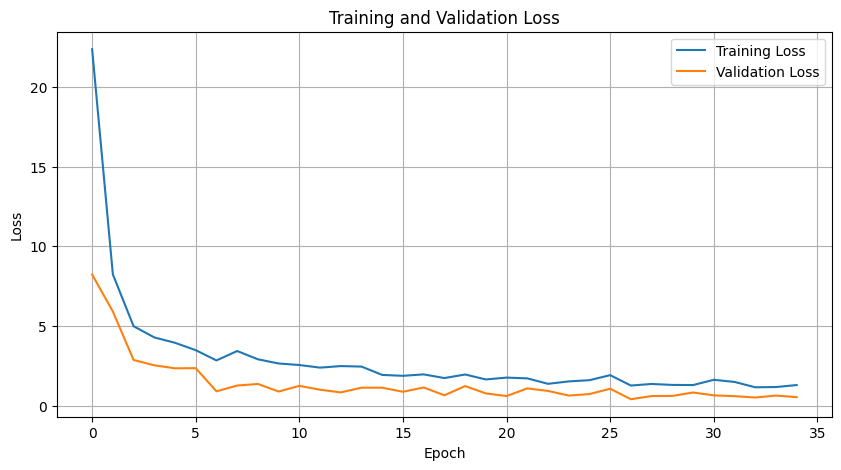


Model saved to 'v4_ResNet.pth'


In [18]:
# Initialize model and training components
model = SteeringResNet()
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)  # Changed to AdamW with weight decay

# Train the model
model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50,
    patience=8
)

# Save the trained model
torch.save(model.state_dict(), 'v4_ResNet.pth')
print("\nModel saved to 'v4_ResNet.pth'")


Testing the model...

Test Results (Predicting Steering Angle at t+200ms):
MSE: 0.5623 degrees²
MAE: 0.5013 degrees
Predictions within 1°: 87.2%
Predictions within 3°: 99.3%
Predictions within 5°: 99.9%


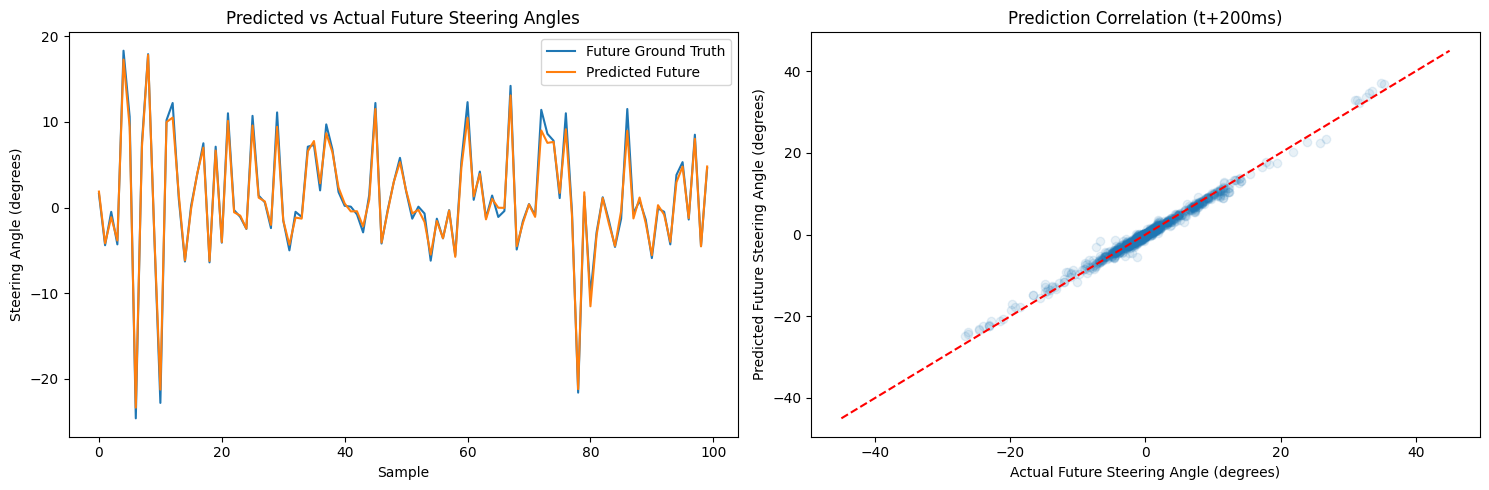


Visualizing some predictions...


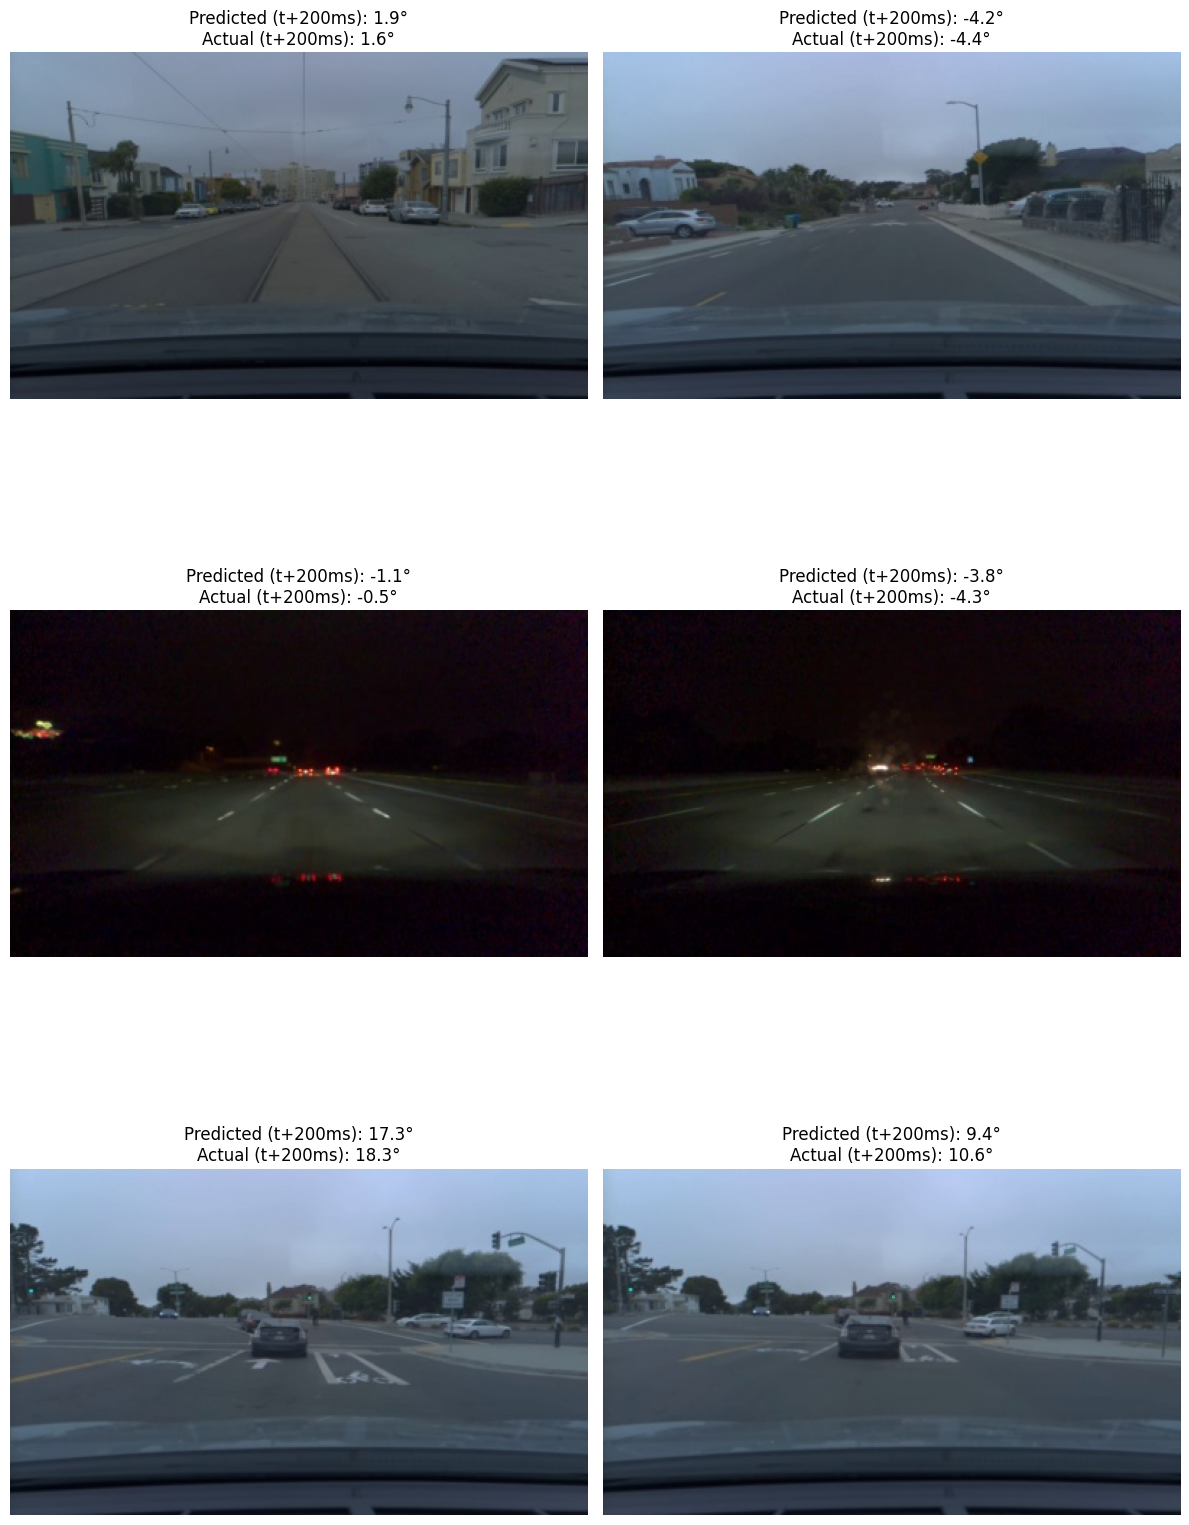

In [19]:
# Test the model
print("\nTesting the model...")
test_model(model, test_loader)

def visualize_single_batch(model, test_loader):
    model.eval()
    device = next(model.parameters()).device

    # Get a single batch
    images, sensor_data, targets = next(iter(test_loader))
    images = images.to(device)
    sensor_data = sensor_data.to(device)

    with torch.no_grad():
        predictions = model(images, sensor_data)

    # Convert to numpy for visualization
    predictions = predictions.cpu().numpy()
    targets = targets.numpy()

    # Plot a few examples
    fig, axes = plt.subplots(3, 2, figsize=(12, 18))
    for i in range(min(6, len(predictions))):
        ax = axes[i//2, i%2]

        # Get the original image
        img = images[i].cpu().numpy().transpose(1, 2, 0)  # Changed inputs to images

        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(f'Predicted (t+200ms): {predictions[i][0]:.1f}°\nActual (t+200ms): {targets[i]:.1f}°')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\nVisualizing some predictions...")
visualize_single_batch(model, test_loader)